<div style="background-color: #ccffcc; padding: 10px;">
    <h1> Tutorial 2 </h1> 
    <h2> Physics Informed Neural Networks Part 2</h2>
    <h2> Burgers Equation Example </h2>
</div>    

# Overview

This notebook is based on two papers: *[Physics-Informed Neural Networks:  A Deep LearningFramework for Solving Forward and Inverse ProblemsInvolving Nonlinear Partial Differential Equations](https://www.sciencedirect.com/science/article/pii/S0021999118307125)* and *[Hidden Physics Models:  Machine Learning of NonlinearPartial Differential Equations](https://www.sciencedirect.com/science/article/pii/S0021999117309014)* with the help of  Fergus Shone and Michael Macraild.

These tutorials will go through solving Partial Differential Equations using Physics Informed Neuaral Networks focusing on the Burgers Equation and a more complex example using the Navier Stokes Equation

**This introduction section is replicated in all PINN tutorial notebooks (please skip if you've already been through)** 

<div style="background-color: #ccffcc; padding: 10px;">
If you have not already then in your repositoy directory please run the following code. 
    
```bash
git submodule init
git submodule update --init --recursive
```
    
</div>

<div style="background-color: #ccffcc; padding: 10px;">

<h1>Physics Informed Neural Networks</h1>

For a typical Neural Network using algorithims like gradient descent to look for a hypothesis, data is the only guide, however if the data is noisy or sparse and we already have governing physical models we can use the knowledge we already know to optamize and inform the algoithms. This can be done via [feature enginnering]() or by adding a physicall inconsistency term to the loss function.
<a href="https://towardsdatascience.com/physics-guided-neural-networks-pgnns-8fe9dbad9414">
<img src="https://miro.medium.com/max/700/1*uM2Qh4PFQLWLLI_KHbgaVw.png">
</a>   
  
 
## The very basics

If you know nothing about neural networks there is a [toy neural network python code example](https://github.com/cemac/LIFD_ENV_ML_NOTEBOOKS/tree/main/ToyNeuralNetwork) included in the [LIFD ENV ML Notebooks Repository]( https://github.com/cemac/LIFD_ENV_ML_NOTEBOOKS). Creating a 2 layer neural network to illustrate the fundamentals of how Neural Networks work and the equivlent code using the python machine learning library [tensorflow](https://keras.io/). 

    
## Recommended reading 
    
The in-depth theory behind neural networks will not be covered here as this tutorial is focusing on application of machine learning methods. If you wish to learn more here are some great starting points.   

* [All you need to know on Neural networks](https://towardsdatascience.com/nns-aynk-c34efe37f15a) 
* [Introduction to Neural Networks](https://victorzhou.com/blog/intro-to-neural-networks/)
* [Physics Guided Neural Networks](https://towardsdatascience.com/physics-guided-neural-networks-pgnns-8fe9dbad9414)
* [Maziar Rassi's Physics informed GitHub web Page](https://maziarraissi.github.io/PINNs/)

</div>


<hr>


<div style="background-color: #e6ccff; padding: 10px;">
    
<h1> Machine Learning Theory </h1>
<a href="https://victorzhou.com/series/neural-networks-from-scratch/">
<img src="https://victorzhou.com/media/nn-series/network.svg">
</a>

    
## Physics informed Neural Networks

Neural networks work by using lots of data to calculate weights and biases from data alone to minimise the loss function enabling them to act as universal fuction approximators. However these loose their robustness when data is limited. However by using know physical laws or empirical validated relationships the solutions from neural networks can be sufficiently constrianed by disregardins no realistic solutions.
    
A Physics Informed Nueral Network considers a parameterized and nonlinear partial differential equation in the genral form;
$$
\begin{align}
     u_t + \mathcal{N}[u; \lambda] &= 0, && x \in \Omega, t \in [0,T],\\
\end{align}
$$

where $\mathcal{u(t,x)}$ denores the hidden solution, $\mathcal{N}$ is a nonlinear differential operator acting on $u$, $\mathcal{\lambda}$ and $\Omega$ is a \subset of \mathbb{R}^D$ (the perscribed data). This set up an encapuslate a wide range of problems such as diffusion processes, conservation laws,  advection-diffusion-reaction  systems,  and  kinetic  equations and conservation laws. 

Here we will go though this for the Burgers equation and Navier stokes equations


</div>    

<div style="background-color: #cce5ff; padding: 10px;">

<h1> Python </h1>

    
## Tensorflow 
    
There are many machine learning python libraries available, [TensorFlow](https://www.tensorflow.org/) a is one such library. If you have GPUs on the machine you are using TensorFlow will automatically use them and run the code even faster!

## Further Reading

* [Running Jupyter Notebooks](https://jupyter.readthedocs.io/en/latest/running.html#running)
* [Tensorflow optimizers](https://www.tutorialspoint.com/tensorflow/tensorflow_optimizers.htm)

</div>
    
<hr>

<div style="background-color: #ffffcc; padding: 10px;">
    
<h1> Requirements </h1>

These notebooks should run with the following requirements satisfied

<h2> Python Packages: </h2>

* Python 3
* tensorflow > 2
* numpy as np
* matplotlib
* scipy

<h2> Data Requirements</h2>
    
This notebook referes to some data included in the git hub repositroy
    
</div>


**Contents:**

1. [1D Heat Equation Non ML Example](PINNs_1DHeatEquations_nonML.ipynb)
2. **[Burgers Equation PINN Example](PINNs_BurgersEquationExample.ipynb)**
3. [Navier-Stokes PINNs discovery of PDE’s](PINNs_Navier_Stokes_example.ipynb)


<div style="background-color: #cce5ff; padding: 10px;">
Load in all required modules (includig some auxillary code) and turn off warnings. Make sure Keras session is clear
</div>

In [1]:
# For readability: disable warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.insert(0, 'PINNs/Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from time import time
import scipy.sparse as sp
import scipy.sparse.linalg as la

2021-07-16 14:45:32.989702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-16 14:45:32.989724: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<hr>

# Solving via Neural Networks

<div style="background-color: #e6ccff; padding: 10px;">

The Physics Informed Nueral Network approach for approximating the solution $u:[0,T] \times \mathcal{D} \to \mathbb{R}$ of an evolution equation

$$
\begin{align}
    \partial_t u (t,x) + \mathcal{N}[u](t,x) &= 0, && (t,x) \in (0,T] \times \mathcal{D},\\
    u(0,x) &= u_0(x) \quad && x \in \mathcal{D},
\end{align}
$$

where $\mathcal{N}$ is a nonlinear differential operator acting on $u$, 
$\mathcal{D} \subset \mathbb{R}^d$ a bounded domain,
$T$ denotes the final time and
$u_0: \mathcal{D} \to \mathbb{R}$ the prescribed initial data.
Although the methodology allows for different types of boundary conditions, this example is restricted to the inhomogeneous [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_boundary_condition) case :

$$
\begin{align}
        \hspace{7em} u(t,x) &= u_b(t,x)  && \quad (t,x) \in (0,T] \times \partial \mathcal{D},
\end{align}
$$

where $\partial \mathcal{D}$ denotes the boundary of the domain $\mathcal{D}$ and $u_b: (0,T] \times \partial \mathcal{D} \to \mathbb{R}$ the given boundary data.

</div>

<hr>


<div style="background-color: #e6ccff; padding: 10px;">

    
## Methodology

The method constructs a neural network approximation

$$
u_\theta(t,x) \approx u(t,x)
$$

of the solution of nonlinear PDE, where $u_\theta :[0,T] \times \mathcal{D} \to \mathbb{R}$ denotes a function realized by a neural network with parameters $\theta$.

The continuous time approach for the parabolic PDE as described in ([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)) is based on the (strong) residual of a given neural network approximation $u_\theta \colon [0,T] \times \mathcal{D} \to \mathbb{R} $ of the solution $u$, i.e.,

$$
\begin{align}
    r_\theta (t,x) := \partial_t u_\theta (t,x) + \mathcal{N}[u_\theta] (t,x).
\end{align}
$$

To incorporate this PDE residual $r_\theta$ into a loss function to be minimized, PINNs require a further differentiation to evaluate the differential operators $\partial_t u_\theta$ and $\mathcal{N}[u_\theta]$.
Thus the PINN term $r_\theta$ shares the same parameters as the original network $u_\theta(t,x)$, but respects the underlying "physics" of the nonlinear PDE.
Both types of derivatives can be easily determined through automatic differentiation with TensorFlow.

The PINN approach for the solution of the initial and boundary value problem now proceeds by minimization of the mean squared error loss (MSE)

    

$$
MSE = MSE_u + MSE_f,
$$

where

$$
MSE_u = \frac{1}{N_u}\sum_{i=1}^{N_u} |u(t^i_u,x_u^i) - u^i|^2,
$$

and

$$
MSE_f = \frac{1}{N_f}\sum_{i=1}^{N_f}|f(t_f^i,x_f^i)|^2.
$$

Here, $$\{t_u^i, x_u^i, u^i\}_{i=1}^{N_u}$$ denote the initial and boundary training data on $$u(t,x)$$ and $$\{t_f^i, x_f^i\}_{i=1}^{N_f}$$ specify the collocations points for $$f(t,x)$$. The loss $$MSE_u$$ corresponds to the initial and boundary data while $$MSE_f$$ enforces the structure imposed by the Burgers' equation at a finite set of collocation points.


Note that the training data $X$ consists entirely of time-space coordinates.    

</div>

<hr>
<div style="background-color: #ccffcc; padding: 10px;">

## Example: [Burgers' equation](https://en.wikipedia.org/wiki/Burgers%27_equation)

To illustrate the PINN approach we consider the one-dimensional Burgers equation on the spatial domain $\mathcal{D} = [-1,1]$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

This PDE arises in various disciplines such as traffic flow, fluid mechanics and gas dynamics, and can be derived from the Navier-Stokes equations, see 
([Basdevant et al., 1986](https://www.researchgate.net/publication/222935980_Spectral_and_finite_difference_solutions_of_Burgers_equation)).
    

Let us define $$f(t,x)$$ to be given by

$$
f := u_t + u u_x - (0.01/\pi) u_{xx},
$$

and proceed by approximating $u(t,x)$ by a deep neural network.
   
</div>   

<hr>
<div style="background-color: #ccffcc; padding: 10px;">

**$u(x,t)$** can then be defined below as the function `net_u` and the physics informed neural network **$f(x,t)$** is outline in function `net_f`

</div>

In [3]:
def neural_net(X, weights, biases,lb,ub):
    num_layers = len(weights) + 1

    H = 2.0*(X - lb)/(ub - lb) - 1.0
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.tanh(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y

def net_u(x_tf, t_tf, weights, biases, lb, ub):  
    u = neural_net(tf.concat([x_tf,t_tf],1), weights, biases, lb, ub)
    return u

def net_f(x_tf, t_tf, weights, biases,lb, ub, lambda_1, lambda_2): 
    lambda_1 = lambda_1  
    lambda_2 = tf.exp(lambda_2)
    u = net_u(x_tf,t_tf,weights, biases, lb, ub)
    u_t = tf.gradients(u, t_tf)[0]
    u_x = tf.gradients(u, x_tf)[0]
    u_xx = tf.gradients(u_x, x_tf)[0]
    f = u_t + lambda_1*u*u_x - lambda_2*u_xx
    return f

<hr>
<div style="background-color: #ccffcc; padding: 10px;">
    
###  Intialise everying 
    
the `init` function will take our gridded data X and U initialised it building our neural networks from the functions defined above ready to train the model


    
</div>

In [4]:
def xavier_init( size):
    in_dim = size[0]
    out_dim = size[1]        
    xavier_stddev = np.sqrt(2/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

def initialize_NN( layers):        
    weights = []
    biases = []
    num_layers = len(layers) 
    for l in range(0,num_layers-1):
        W = xavier_init(size=[layers[l], layers[l+1]])
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)
        biases.append(b)        
    return weights, biases

def init(X, u, layers, lb, ub):
        
        tf.compat.v1.disable_eager_execution()
        x = X[:,0:1]
        t = X[:,1:2]
        
        
        layers = layers
        
        # Initialize NN
        weights, biases = initialize_NN(layers)  
        
        # tf placeholders and graph
        sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        # Initialize parameters
        lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        lambda_2 = tf.Variable([-6.0], dtype=tf.float32)
     
        

        x_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, x.shape[1]])
        t_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, t.shape[1]])
        u_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, u.shape[1]])
        
        u_pred = net_u(x_tf, t_tf,weights, biases, lb, ub)
        f_pred = net_f(x_tf, t_tf,weights, biases,lb, ub,lambda_1, lambda_2)

        loss = tf.reduce_mean(tf.square(u_tf - u_pred)) + \
                    tf.reduce_mean(tf.square(f_pred))
        optimizer = tf.compat.v1.train.AdamOptimizer()
        optimizer_Adam = tf.compat.v1.train.AdamOptimizer()
        train_op_Adam = optimizer_Adam.minimize(loss)                    

        init = tf.compat.v1.global_variables_initializer()
        sess.run(init)
        xvars=[X,lb,ub,x,t,u]
        NNvars=[layers, weights, biases, lambda_1, lambda_2]
        tfvars=[sess, x_tf, t_tf ,u_tf]
        preds=[u_pred, f_pred]
        optvars=[loss, optimizer,optimizer_Adam,train_op_Adam]
        return xvars,NNvars,tfvars,preds,optvars

<div style="background-color: #ccffcc; padding: 10px;">

# Load data and set input parameters 
    
A feedforward neural network of the following structure is assumed:
- the input is scaled elementwise to lie in the interval $[-1,1]$,
- followed by 8 fully connected layers each containing 20 neurons and each followed by a hyperbolic tangent activation function,
- one fully connected output layer.

This setting results in a network with a first hidden layer: $2 \cdot 20 + 20 = 60$; $9$ intermediate layers: each $20 \cdot 20 + 20 = 540$; output layer: $20 \cdot 1 + 1 = 21$).
</div>

 <div style="background-color: #cce5ff; padding: 10px;">
    
# Number of collocation points 
    
`2000` colloction points is the default setting for this example this can be increased to improve results at cost of computational speed. The original work set this `N_u=10000` running on GPU's in a few minutes. On a   
    
</div>

In [5]:
nu = 0.01/np.pi # exact lambda 2
N_u = 2000 # Coloaction points 
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
data = scipy.io.loadmat("PINNs/appendix/Data/burgers_shock.mat")
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
# Set number of data points
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds (-1,1)
lb = X_star.min(0)
ub = X_star.max(0)  

# Noiseless
noise = 0.0     

# Select our training data
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

<div style="background-color: #ccffcc; padding: 10px;">

# Initalise the nerual network 
    
`init` is called passing in the training data `X_u_train` and `u_train` with information about the neural network layers and bounds `lb` `ub`
    
# Extract vars
    
`init` reformats some of the data and outputs model features that we need to pass into the training function `train`

</div>

In [6]:
xvars, NNvars, tfvars, preds, optvars = init(X_u_train, u_train, layers, lb, ub)
X,lb,ub,x,t,u=xvars
layers, weights, biases, lambda_1, lambda_2=NNvars
sess, x_tf, t_tf ,u_tf=tfvars
u_pred, f_pred,=preds
loss, optimizer,optimizer_Adam,train_op_Adam=optvars

Device mapping: no known devices.


2021-07-16 14:45:34.208351: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-16 14:45:34.208821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-16 14:45:34.208834: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-16 14:45:34.208848: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (marvin): /proc/driver/nvidia/version does not exist


truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal: (Add): /job:localhost/replica:0/task:0/device:CPU:0
Variable/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Assign: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Read/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Assign: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Read/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
trunca

2021-07-16 14:45:35.441907: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:45:35.441934: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:45:35.441942: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal: (Add): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:45:35.441948: I tensorflow/core/common_runtime/placer.cc:114] Variable/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:45:35.441955: I tensorflow/core/common_runtime/placer.cc:114] Variable/Assign: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:45:35.441960: I tensorflow/core/common_runtime/placer.cc:114] Variable/Read/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:45:

In [7]:

def train(sess, nIter,x_tf, t_tf, u_tf,x, t,u_train, loss, train_op_Adam, optimizer_Adam): 
    tf_dict = {x_tf: x,  t_tf: t, u_tf: u}

    start_time = time()
    for it in range(nIter):
        sess.run(train_op_Adam, tf_dict)

    # Print
    if it % 10 == 0:
        elapsed = time() - start_time
        loss_value = sess.run(loss, tf_dict)
        lambda_1_value = sess.run(lambda_1)
        lambda_2_value = sess.run(lambda_2)
        print('It: %d, Loss: %.3e, l1: %.3f, l2: %.5f, Time: %.2f' % 
            (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
        start_time = time()

    optimizer.minimize(loss)
    

<div style="background-color: #cce5ff; padding: 10px;">

**Training might take a while depending on value of Train_interations**

If you set Train_iterations too low the end results will be garbage. 20000 was used to achieve excellent results. 

* If you are using a machine with GPUs please set `Train_interations` to 20000 and this will run quickly
* If you are using a well spec'ed laptop/computer and can leave this setting `Train_interations=20000` but it will take upto 10 mins
* If you are using a low spec'ed laptop/computer or cannont leave the code running `Train_interations=10000` is the reccomended value (this solution may not be accurate)
    
</div>

In [8]:
# Training
Train_interations=20000

In [9]:
train(sess, Train_interations,x_tf, t_tf, u_tf,x, t,u_train, loss, train_op_Adam, optimizer_Adam)


<div style="background-color: #ccffcc; padding: 10px;">

# Use trained model to predict from data sample
    
`predict` will predict `u` using the trained model

</div>

In [10]:

def predict(x_star,u_star, u_pred, f_pred):

   
    tf_dict = {x_tf: x_star, t_tf: u_star}
    u_star = sess.run(u_pred, tf_dict)
    f_star = sess.run(f_pred, tf_dict)
    

    return u_star, f_star

In [11]:
u_pred, f_pred=preds
u_pred, f_pred = predict(X_star[:,0:1],X_star[:,1:2], u_pred, f_pred)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

2021-07-16 14:48:54.832941: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:54.832977: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:54.832985: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal: (Add): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:54.832992: I tensorflow/core/common_runtime/placer.cc:114] Variable: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:54.832998: I tensorflow/core/common_runtime/placer.cc:114] Variable/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:54.833003: I tensorflow/core/common_runtime/placer.cc:114] Variable/Assign: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:54.833009: I tensorflow

st/replica:0/task:0/device:CPU:0
Variable_15/Adam_1: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_16/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_16/Adam: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_16/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_16/Adam_1: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_17/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_17/Adam: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_17/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_17/Adam_1: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_18/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_18/Adam: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_18/Adam_1/Initializer/zeros: (

<div style="background-color: #ccffcc; padding: 10px;">

# Calculate Errors
    
if you have set the number of training interations large enough the errors should be small. **NB** as `lambda 2` is very small itself $(0.003)$ this error might be failry high with out affecting the qualitative prediction 

</div>

In [12]:
lambda_1_value = sess.run(lambda_1)
lambda_2_value = sess.run(lambda_2)
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0)*100
error_lambda_2 = np.abs(lambda_2_value - nu)/nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

Error u: 1.580417e-02
Error l1: 3.90818%
Error l2: 13.40698%


In [13]:
noise = 0.01        
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
xvars, NNvars, tfvars, preds, optvars = init(X_u_train, u_train, layers, lb, ub)
X,lb,ub,x,t,u=xvars
layers, weights, biases, lambda_1, lambda_2=NNvars
sess, x_tf, t_tf ,u_tf=tfvars
u_pred, f_pred,=preds
loss, optimizer,optimizer_Adam,train_op_Adam=optvars

Device mapping: no known devices.


2021-07-16 14:48:56.499171: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:56.499203: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:56.499213: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal: (Add): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:56.499220: I tensorflow/core/common_runtime/placer.cc:114] Variable/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:56.499228: I tensorflow/core/common_runtime/placer.cc:114] Variable/Assign: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:56.499234: I tensorflow/core/common_runtime/placer.cc:114] Variable/Read/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:

0/device:CPU:0
Adam_1/learning_rate: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Adam_1/beta1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Adam_1/beta2: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Adam_1/epsilon: (Const): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal: (Add): /job:localhost/replica:0/task:0/device:CPU:0
Variable/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Assign: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Read/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Assign: (AssignVariableOp): /job:localhost/replica:0/

ore/common_runtime/placer.cc:114] gradients_8/Add_21_grad/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:56.681356: I tensorflow/core/common_runtime/placer.cc:114] gradients_8/Add_21_grad/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:56.681361: I tensorflow/core/common_runtime/placer.cc:114] gradients_8/Add_21_grad/Sum: (Sum): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:56.681366: I tensorflow/core/common_runtime/placer.cc:114] gradients_8/Add_21_grad/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:56.681371: I tensorflow/core/common_runtime/placer.cc:114] gradients_8/Add_21_grad/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:56.681376: I tensorflow/core/common_runtime/placer.cc:114] gradients_8/Add_21_grad/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:48:56.681381: I tensorfl

/gradients_6/Tanh_29_grad/TanhGrad_grad/mul_2_grad/tuple/control_dependency: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
gradients_8/gradients_7/gradients_6/Tanh_29_grad/TanhGrad_grad/mul_2_grad/tuple/control_dependency_1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
gradients_8/gradients_7/MatMul_33_grad/MatMul_grad/MatMul: (MatMul): /job:localhost/replica:0/task:0/device:CPU:0
gradients_8/gradients_7/MatMul_33_grad/MatMul_grad/MatMul_1: (MatMul): /job:localhost/replica:0/task:0/device:CPU:0
gradients_8/gradients_7/MatMul_33_grad/MatMul_grad/tuple/group_deps: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
gradients_8/gradients_7/MatMul_33_grad/MatMul_grad/tuple/control_dependency: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
gradients_8/gradients_7/MatMul_33_grad/MatMul_grad/tuple/control_dependency_1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
gradients_8/gradients_5/Tanh_31_grad/TanhGrad_grad/mul: (Mul): /job:localhost/replica

<div style="background-color: #cce5ff; padding: 10px;">

**Training might take a while depending on value of Train_interations**

If you set Train_iterations too low the end results will be garbage. 20000 was used to achieve excellent results. 

* If you are using a machine with GPUs please set `Train_interations` to 20000 and this will run quickly
* If you are using a well spec'ed laptop/computer and can leave this setting `Train_interations=20000` but it will take upto 10 mins
* If you are using a low spec'ed laptop/computer or cannont leave the code running `Train_interations=10000` is the reccomended value (this solution may not be accurate)
    
</div>

In [14]:
Train_interations=20000

In [15]:
train(sess, Train_interations,x_tf, t_tf, u_tf,x, t,u_train, loss, train_op_Adam, optimizer_Adam)

In [16]:
u_pred, f_pred=preds
u_pred, f_pred = predict(X_star[:,0:1],X_star[:,1:2], u_pred, f_pred)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)


2021-07-16 14:52:22.183033: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:52:22.183068: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:52:22.183077: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal: (Add): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:52:22.183085: I tensorflow/core/common_runtime/placer.cc:114] Variable: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:52:22.183091: I tensorflow/core/common_runtime/placer.cc:114] Variable/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:52:22.183097: I tensorflow/core/common_runtime/placer.cc:114] Variable/Assign: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:52:22.183103: I tensorflow

PU:0
Variable_33/Adam: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_33/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_33/Adam_1: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_34/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_34/Adam: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_34/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_34/Adam_1: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_35/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_35/Adam: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_35/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_35/Adam_1: (VarHandleOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_36/Adam/Initializer/zeros: (Const): /job:localhost/repli

rad/BroadcastTo: (BroadcastTo): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:52:22.364509: I tensorflow/core/common_runtime/placer.cc:114] gradients_8/Add_37_grad/Shape: (Shape): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:52:22.364514: I tensorflow/core/common_runtime/placer.cc:114] gradients_8/Add_37_grad/Shape_1: (Shape): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:52:22.364519: I tensorflow/core/common_runtime/placer.cc:114] gradients_8/Add_37_grad/BroadcastGradientArgs: (BroadcastGradientArgs): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:52:22.364524: I tensorflow/core/common_runtime/placer.cc:114] gradients_8/Add_37_grad/Sum: (Sum): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:52:22.364529: I tensorflow/core/common_runtime/placer.cc:114] gradients_8/Add_37_grad/Reshape: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
2021-07-16 14:52:22.364534: I tensorflow/core/common_runtime/placer.cc:114] gradient

_7/AddN_5_grad/tuple/control_dependency: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
gradients_8/gradients_7/AddN_5_grad/tuple/control_dependency_1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
gradients_8/MatMul_19_grad/MatMul: (MatMul): /job:localhost/replica:0/task:0/device:CPU:0
gradients_8/MatMul_19_grad/MatMul_1: (MatMul): /job:localhost/replica:0/task:0/device:CPU:0
gradients_8/MatMul_19_grad/tuple/group_deps: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
gradients_8/MatMul_19_grad/tuple/control_dependency: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
gradients_8/MatMul_19_grad/tuple/control_dependency_1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
gradients_8/gradients_5/Add_31_grad/Sum_grad/Shape: (Shape): /job:localhost/replica:0/task:0/device:CPU:0
gradients_8/gradients_5/Add_31_grad/Sum_grad/add: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
gradients_8/gradients_5/Add_31_grad/Sum_grad/mod: (FloorMod): /job:lo

In [17]:
lambda_1_value_noisy = sess.run(lambda_1)
lambda_2_value_noisy = sess.run(lambda_2)
lambda_2_value_noisy = np.exp(lambda_2_value)
error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0)*100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu)/nu * 100

In [18]:

print('Error lambda_1: %f%%' % (error_lambda_1_noisy))
print('Error lambda_2: %f%%' % (error_lambda_2_noisy))

Error lambda_1: 3.992426%
Error lambda_2: 31429.535156%


In [19]:
# Set grid values back to full data set size for plotting

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
X, T = np.meshgrid(x,t) 

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

<div style="background-color: #ccffcc; padding: 10px;">

# Plot Exact and Precticed $(u,t)$
    


</div>

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Precticted $u(x,t)$')

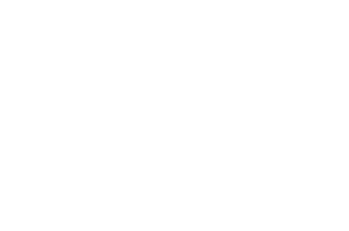

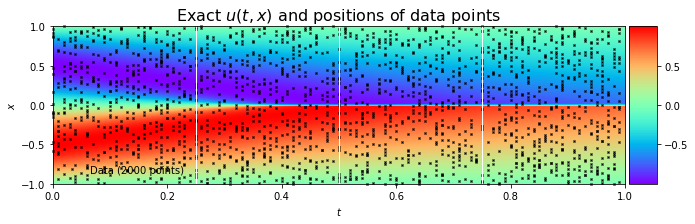

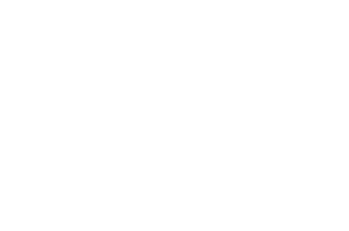

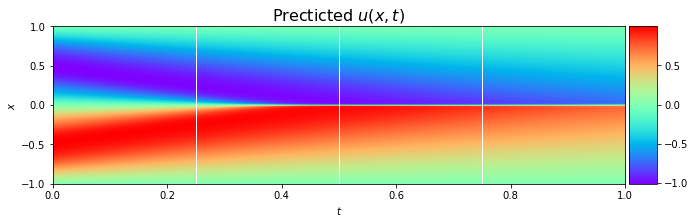

In [20]:
fig, ax = plt.subplots()
ax.axis('off')

####### Row 0: u(t,x) ################## 
plt.figure(figsize=(12,8))
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(Exact.T, cmap='rainbow', 
              extent=[0, 1, -1, 1], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 2, clip_on = False)
    
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('Exact $u(t,x)$ and positions of data points', fontsize = 16)

fig, ax = plt.subplots()
ax.axis('off')
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
X, T = np.meshgrid(x,t) 
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
####### Row 0: u(t,x) ################## 
plt.figure(figsize=(12,8))
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, cmap='rainbow', 
              extent=[0, 1, -1, 1], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
X, T = np.meshgrid(x,t)  
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('Precticted $u(x,t)$', fontsize = 16)




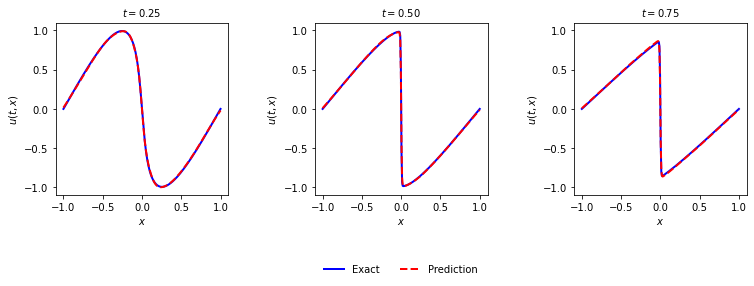

In [21]:
plt.figure(figsize=(12, 6))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred.T[:,25], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred.T[:,50], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x, U_pred.T[:,75], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)

plt.tight_layout()

Text(0, 0, 'Correct PDE \n $u_t + u u_x - 0.0031831 u_{xx} = 0$ \n \n \nIdentified PDE (clean data) \n$u_t + 0.96092 u u_x - 0.0036099 u_{xx} = 0$  \n\n \nIdentified PDE (1% noise) & \n$u_t + 0.96008 u u_x - 1.0036163 u_{xx} = 0$ ')

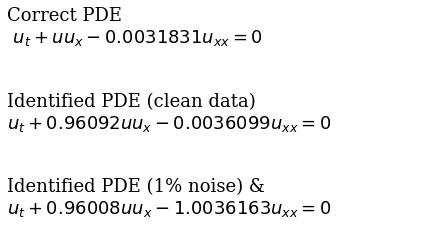

In [22]:
######## Row 3: Table #######################
gs3 = gridspec.GridSpec(1, 2)
gs3.update(top=1-1/2, bottom=0.0, left=0.0, right=1.0, wspace=0)
ax = plt.subplot(gs3[:, :])
ax.axis('off')
plt.rc('text', usetex=False)
s=''
s = s + "Correct PDE \n "
s = s+ '$u_t + u u_x - 0.0031831 u_{xx} = 0$ '
s = s + "\n \n \n"
s = s + r'Identified PDE (clean data) '
s = s + "\n"
s = s + '$u_t + %.5f u u_x - %.7f u_{xx} = 0$  ' % (lambda_1_value, lambda_2_value) 

s = s + "\n\n \n"

s = s + r'Identified PDE (1% noise) & '
s = s + "\n"
s = s + r'$u_t + %.5f u u_x - %.7f u_{xx} = 0$ ' % (lambda_1_value_noisy, lambda_2_value_noisy)

plt.rc('font',family='serif')

plt.rc('font',size=16)
ax.text(0,0,s,fontsize=18)

# savefig('./figures/NavierStokes_prediction') 

<hr>


<div style="background-color: #e6ccff; padding: 10px;">
    
# Next Steps
    
    
Next we move on to a more complex example using the Navier Stokes Equation in the notebook linked below
  
[Navier-Stokes PINNs discovery of PDE’s](PINNs_Navier_Stokes_example.ipynb)
    
 <hr>

